In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE


import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import string
import re

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#gpu
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!pip install -U -q PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
file_list = drive.ListFile({'q': "'1DKJEpwYEPfGzEOzZZ1TwVM_pZIc4RnbF' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: train.csv, id: 1piDuPiqjKJzF2W1g134KlnKFCaGJNId6


In [0]:
train_downloaded = drive.CreateFile({'id': '1piDuPiqjKJzF2W1g134KlnKFCaGJNId6'})
train_downloaded.GetContentFile('train.csv')

In [0]:
import pandas as pd

data = pd.read_csv('train.csv')

In [9]:
data.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
id        20800 non-null int64
title     20242 non-null object
author    18843 non-null object
text      20761 non-null object
label     20800 non-null int64
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html


In [0]:
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"[^a-zA-z\s]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    ##remove less than 4 letters
    text = re.sub(r'\b\w{1,3}\b', '', text)
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    return text


In [0]:
#data prep
data=data.fillna(' ')
data['all'] = data['author'] +' '+ data['title'] +' '+ data['text']

# apply the above function to data['all']
data['all'] = data['all'].map(lambda x: clean_text(x))


In [0]:
#data all lenght
data['all_length'] = data['all'].apply(len)

In [14]:
data['all_length'].describe(percentiles=[.10, .30, .65, .80])

count    20800.000000
mean      2621.696731
std       2806.063755
min          0.000000
10%        411.000000
30%       1152.000000
50%       1971.500000
65%       2881.000000
80%       3999.000000
max      68134.000000
Name: all_length, dtype: float64

In [15]:
#word frequency dist
vocabulary_size = len(data['all'].unique().tolist())
print(vocabulary_size)

20578


In [16]:
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

# Create sequence
maxlen = 1000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(data['all'])
sequences = tokenizer.texts_to_sequences(data['all'])
train = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

labels = data['label'].values
print(train)

Using TensorFlow backend.


[[ 7409 12921    40 ...     0     0     0]
 [ 1560  1862  1862 ...     0     0     0]
 [ 7196   603   157 ...     0     0     0]
 ...
 [  559 11300  3957 ...     0     0     0]
 [ 2017  6665   900 ...     0     0     0]
 [  609  8312   194 ...     0     0     0]]


In [17]:
# Network architecture
model = Sequential()
model.add(Embedding(vocabulary_size, 128, input_length = maxlen))
model.add(Dropout(0.20))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(196))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
history_lstm = model.fit(train, np.array(labels), validation_split=0.2, batch_size = 32, epochs=5)

Train on 16640 samples, validate on 4160 samples
Epoch 1/5
16640/16640 [==============================] - 332s 20ms/step - loss: 0.6925 - acc: 0.5087 - val_loss: 0.6863 - val_acc: 0.5075
Epoch 2/5
 2816/16640 [====>.........................] - ETA: 4:20 - loss: 0.6843 - acc: 0.5252

16640/16640 [==============================] - 332s 20ms/step - loss: 0.6328 - acc: 0.5917 - val_loss: 0.4904 - val_acc: 0.8317
Epoch 3/5
 9056/16640 [===============>..............] - ETA: 2:22 - loss: 0.2683 - acc: 0.8954

16640/16640 [==============================] - 331s 20ms/step - loss: 0.2111 - acc: 0.9200 - val_loss: 0.1098 - val_acc: 0.9666
Epoch 4/5
11424/16640 [===================>..........] - ETA: 1:38 - loss: 0.0815 - acc: 0.9760

16640/16640 [==============================] - 331s 20ms/step - loss: 0.0727 - acc: 0.9790 - val_loss: 0.0638 - val_acc: 0.9805
Epoch 5/5
12320/16640 [=====================>........] - ETA: 1:21 - loss: 0.0300 - acc: 0.9929

16640/16640 [==============================] - 331s 20ms/step - loss: 0.0298 - acc: 0.9930 - val_loss: 0.0484 - val_acc: 0.9844


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



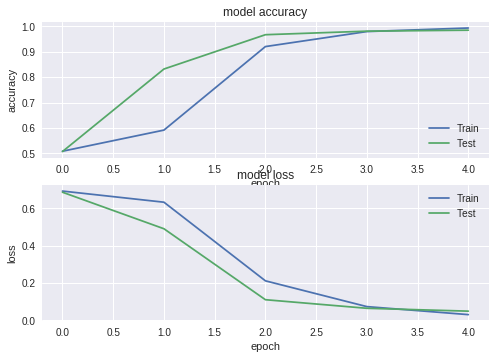

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history_lstm.history['acc'])
plt.plot(history_lstm.history['val_acc'])                
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train',
            'Test'],
            loc='lower right', prop={'size': 10})

plt.subplot(2,1,2)
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])                
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train',
            'Test'],
            loc='upper right', prop={'size': 10})

fig.show()

In [0]:
#Get embedding weights from glove
word_embds = model.layers[0].get_weights()[0]

In [0]:
#Get word list
word_list = []
for word, i in tokenizer.word_index.items():
    word_list.append(word)

In [49]:
#Scatter plot of first two components of TSNE

X_embedded = TSNE(n_components=2).fit_transform(word_embds)
number_of_words = 500
trace = go.Scatter(
    x = X_embedded[0:number_of_words,0], 
    y = X_embedded[0:number_of_words, 1],
    mode = 'markers',
    text= word_list[0:number_of_words]
)
layout = dict(title= 't-SNE 1 vs t-SNE 2 for first 500 words ',
              yaxis = dict(title='t-SNE 2'),
              xaxis = dict(title='t-SNE 1'),
              hovermode= 'closest')
fig = dict(data = [trace], layout= layout)
py.iplot(fig)

KeyboardInterrupt: ignored